In [80]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os

#os.chdir('../')
from src import helper

plt.style.use('ggplot')

## Hypothesis testing on SF Crime database

In order to do hypothesis testing, we need Gaussian distributions. While our underlying distributions in the crime database are not Gaussian, we can take advantage of the CLT in order to test any hypothesis we can dream up. 

Hypothesis 1: There is more crime in the evening in some PD districts

In [42]:
## Load data
data = pd.read_csv('data/2003.csv', parse_dates= ['Time'])
data.head()

# Drop that first column 
data = data.drop(columns='Unnamed: 0')

data.head()

,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y
0,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Sunday,2003-09-07 00:00:00,2020-06-24 11:37:00,SOUTHERN,NONE,500 Block of I-80,-122.386667,37.789882
1,TRESPASS,TRESPASSING,Friday,2003-10-24 00:00:00,2020-06-24 20:15:00,SOUTHERN,NONE,800 Block of MARKET ST,-122.406691,37.785207
2,ASSAULT,THREATS AGAINST LIFE,Wednesday,2003-09-24 00:00:00,2020-06-24 12:15:00,PARK,NONE,1400 Block of PAGE ST,-122.444713,37.771302
3,ASSAULT,BATTERY,Wednesday,2003-02-26 00:00:00,2020-06-24 16:50:00,SOUTHERN,NONE,1400 Block of MARKET ST,-122.418481,37.775898
4,ASSAULT,BATTERY,Monday,2003-03-24 00:00:00,2020-06-24 20:08:00,BAYVIEW,"ARREST, BOOKED",0 Block of APOLLO ST,-122.397783,37.732115


In [43]:
data['Time'][0]

Timestamp('2020-06-24 11:37:00')

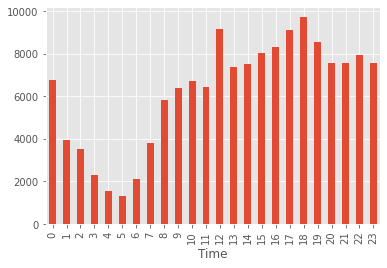

In [48]:
## Look at crimetime, but first resample into hour timeslots
#data['PdDistrict'].resample('H')
data['Category'].groupby(data['Time'].dt.hour).count().plot(kind='bar')

### Resampling and applying CLT
- There are ~150k entries, so let's resample in batches of 100, take the mean, rinse, repeat 10000 times. 

In [70]:
# Testing mean of timeseries. Surprisingly, this works
choice = np.random.choice(50000, 3)
data['Time'][choice], np.mean(data['Time'][choice])

(32583   2020-06-24 01:00:00
 21422   2020-06-24 19:00:00
 46731   2020-06-24 12:30:00
 Name: Time, dtype: datetime64[ns],
 Timestamp('2020-06-24 10:50:00'))

In [91]:
def resample(df_series, n_samples=10, n_iterations=10000) -> pd.Series:
    n_entries = len(df_series)
    samples = []
    
    for n in range(n_iterations):
        s = np.random.choice(n_entries, n_samples, replace=True)
        samples.append(np.mean(df_series.iloc[s]))
    
    return samples    

(array([   7.,   38.,  226.,  583., 1090., 1309., 1057.,  528.,  139.,
          23.]),
 array([737600.35871528, 737600.39980903, 737600.44090278, 737600.48199653,
        737600.52309028, 737600.56418403, 737600.60527778, 737600.64637153,
        737600.68746528, 737600.72855903, 737600.76965278]),
 <a list of 10 Patch objects>)

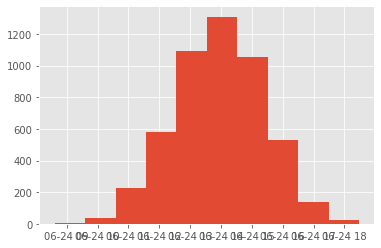

In [97]:
# Proof of concept works! Let's do some testing
s = resample(data['Time'], 20, 5000)
plt.hist(s)

Let's create two different distributions corresponding to:
1. PD District:<br>
    H0: Crime in the Mission happens at the same time (within hour) than in the Ingleside<br>
    H1: Crime in the Mission is offset by more than an hour relative to Ingleside
2. Type of Crime: <br>
    H0: Violent crime happens at the same time as non-violent crime<br>
    H1: Violent crime is offset by an hour or more from other crime

In [81]:
# Start with violent and non-violent crime
v_df, nv_df = helper.violence(data)
v_df.shape, nv_df.shape

In [90]:
nv_df['Time']

0        2020-06-24 11:37:00
1        2020-06-24 20:15:00
6        2020-06-24 21:16:00
7        2020-06-24 18:00:00
8        2020-06-24 01:55:00
                 ...        
149169   2020-06-24 02:00:00
149170   2020-06-24 12:00:00
149171   2020-06-24 10:17:00
149172   2020-06-24 15:24:00
149175   2020-06-24 08:33:00
Name: Time, Length: 131899, dtype: datetime64[ns]

In [170]:
# Resample. Violence will end up being slightly oversampled https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
n_samples = 10
n_iterations = 5000 
v_sample = resample(v_df['Time'].apply(lambda x: x.hour), 
                    n_samples, 
                    n_iterations)
nv_sample = resample(nv_df['Time'].apply(lambda x: x.hour), 
                     n_samples, 
                     n_iterations)

np.mean(v_sample), np.mean(nv_sample), np.var(v_sample), np.var(nv_sample)

(13.195659999999998, 13.640920000000001, 4.566639164400001, 4.0995415536)

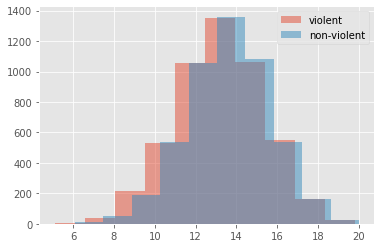

In [169]:
fig, ax = plt.subplots()
ax.hist(v_sample, alpha=0.5, label='violent')
ax.hist(nv_sample, alpha=0.5, label='non-violent')
ax.legend()

Now get into the statistics with steps to compute hypothesis. We are testing the means of two distriubtions
1. State null: mean of violent = mean of nonviolent. Alternative is that u1 is not equal to u2
2. Chose out significance. Let's go with 0.05, or 95% confidence
3. Analyze sample data: calc the standard error of sample data and the test statistic ((u1-u2)/SE)
4. Calculate the p-value

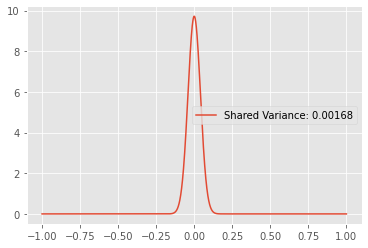

In [144]:
# Null -> distribution of difference between the two is gaussian centered around 0
import scipy.stats as stats
shared_var = np.var(v_sample)/len(v_sample) + np.var(nv_sample)/len(nv_sample)
null = stats.norm(0, np.sqrt(shared_var))

# Plot null
x = np.linspace(-1, 1, 2400)
plt.plot(x, null.pdf(x), label='Shared Variance: {:2.5f}'.format(shared_var))
plt.legend()

In [172]:
# Define test statistic
def standard_error(sample1, sample2):
    term1 = np.var(sample1)/len(sample1)
    term2 = np.var(sample2)/len(sample2)
    return np.sqrt(term1 + term2)

def welchs_test_statistic(sample1, sample2):
    numerator = np.mean(sample1) - np.mean(sample2)
    denominator = standard_error(sample1, sample2)
    return numerator/denominator

# Define degrees of freedom for welch's test
def welchs_dof(sample1, sample2):
    numerator = standard_error(sample1, sample2)**2
    denom_t1 = (np.var(sample1)/len(sample1))**2/(len(sample1)-1)
    denom_t2 = np.var(sample2)/len(sample2)**2/(len(sample2)-1)
    return numerator/(denom_t1 + denom_t2)

In [173]:
test_statistic = welchs_test_statistic(v_sample, nv_sample)
print('Test statistic is {:2.2f}'.format(test_statistic))

Test statistic is -10.70


In [157]:
dof = welchs_dof(v_sample, nv_sample)
dof

8958245.022592671

Our degrees of freedom is so large that we essentially have a normal distribution (smaller dof = larger tails in welchs)

Text(0.5, 1.0, "Distribution of Welch's test statistic under null hypothesis")

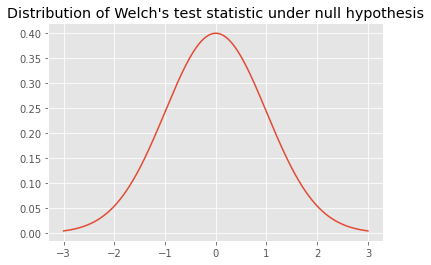

In [159]:
# Plot distribution of welchs
x = np.linspace(-3, 3, 1000)
students = stats.t(dof)

fig, ax = plt.subplots()
ax.plot(x, students.pdf(x))
ax.set_title('Distribution of Welch\'s test statistic under null hypothesis')

In [165]:
# Now use our test statistic to calculate p-value under welchs distribution
p_value = students.cdf(test_statistic) + (1 - students.cdf(-test_statistic))
p_value

2.646105183073659e-35

P-value is very low, so we can conclude that the means of the two distributions are indeed different. But shouldn't how different matter?

In [176]:
# Is nv later than v? so test statistic should be positive
# Note that if nv and v are switched, p value becomes 1
t = welchs_test_statistic(nv_sample, v_sample)
p_val = 1 - students.cdf(t)
print(t, p_val)

10.695099111142397 0.0


#### Conclusion: Non-violent crime on average occurs later than violent crime with a certainty of >99%. 

### Let's try same calculation, but with Rank Sums,which makes no assumptions about the distributions
Using the Mann-Whitney U-test, which is alterantive to Welch's t-test where the two samples "compete" to see which is later/wins/etc

In [179]:
def count_winning_pairs(sample1, sample2):
    sample1, sample2 = np.array(sample1), np.array(sample2)
    n_total_wins = 0
    for x in sample1:
        n_wins = np.sum(x > sample2) + 0.5*np.sum(x == sample2)
        n_total_wins += n_wins
    return n_total_wins

In [180]:
nv_later = count_winning_pairs(nv_sample, v_sample)
v_later = count_winning_pairs(v_sample, nv_sample)
print(f'Number of times nv is later: {nv_later}')
print(f'Number of times v is later: {v_later}')

Number of times nv is later: 14003100.0
Number of times v is later: 10996900.0


In [186]:
# Now apply U test
res1 = stats.mannwhitneyu(nv_sample, v_sample, alternative='greater')
res2 = stats.mannwhitneyu(v_sample, nv_sample, alternative='greater')
res1.pvalue, res2.pvalue

(1.0659671585554878e-25, 1.0)

### We can conclude that non-violent crime occurs later. This is way easier than Welchs t test

In [188]:
## Let's try something trickier. Can we conclude that non-violent crime occurs 1 hour later